# Background Subtraction and Source Detection


**Version 0.1**

By Yusra AlSayyad (Princeton University)

Note: for portability, the examples in this notebook are one-dimensional and avoid using libraries. In practice on real astronomical images, I recommend using a library for astronomical image processing, e.g. AstroPy or the LSST Stack. 

## Background Estimation

A prerequisite to this notebook is the `introductionToBasicStellarPhotometry.ipynb` notebook. We're going to use the same single stellar simulation, but with increasingly complex backgrounds.


First, setup the simulation and necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator

%matplotlib notebook

In [2]:
def pixel_plot(pix, counts, fig=None, ax=None): 
    '''Make a pixelated 1D plot'''
    if fig is None and ax is None:
        fig, ax = plt.subplots()
    
    ax.step(pix, counts, 
            where='post')
    
    ax.set_xlabel('pixel number')
    ax.set_ylabel('relative counts')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    fig.tight_layout()
    return fig, ax

In [3]:
# Define your PSF function phi()
# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook

def phi(x, mu, fwhm):
    """Evalute the 1d PSF N(mu, sigma^2) along x
    
    Parameters
    ----------
    x : array-like of shape (n_pixels,)
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    
    Returns
    -------
    flux : array-like of shape (n_pixels,)
        Flux in each pixel of the input array
    """
    sigmaPerFwhm = 2*np.sqrt(2*np.log(2))
    sigma = fwhm/sigmaPerFwhm 
    flux =  norm.pdf(x, mu, sigma)
    return flux


# Define your image simulation function to
# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook
# Note that the background S should now be supplied as 
# an array of length (S) or a constant. 

def simulate(x, mu, fwhm, S, F):
    """simulate a noisy stellar signal
    
    Parameters
    ----------
    x : array-like
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    S : float or array-like of len(x)
        Sky background for each pixel
    F : float
        Total stellar flux
    
    Returns
    -------
    noisy_counts : array-like (same shape as x)
        the (noisy) number of counts in each pixel
    """
    signal = F * phi(x=x, mu=mu, fwhm=fwhm) + S
    noise = np.random.normal(loc=0, scale=np.sqrt(signal))
    noisy_counts = signal + noise    
    return noisy_counts    


## Problem 1) Simple 1-D Background Estimation


### Problem 1.1) Estimate a the background as a constant offset (order = 0)


For this problem we will use a simulated star with a constant background offset of $S=100$.

Background estimation is typically done by inspecting the distribution of counts in pixel bins. First inspect the distribution of counts, and pick an estimator for the background that is robust to the star (reduces biased fromthe star). Remember that we haven't done detection yet and don't know where the sources are. 


(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110638f60>)

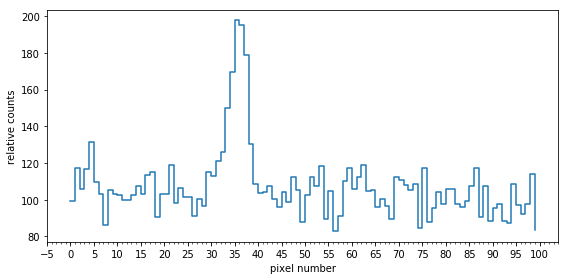

In [4]:
# simulate the star
x = np.arange(100)
mu = 35
S = 100
fwhm = 5
F = 500

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
sim_star = simulate(x, mu=mu, fwhm=fwhm, S=S, F=F)
pixel_plot(x, sim_star, fig=fig, ax=ax)


My background estimate = 104.2049
The mean pixel count = 107.3805


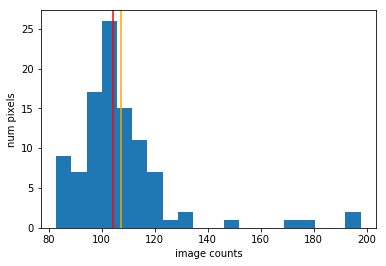

In [5]:
# plot and inspect histogram
fig = plt.figure(figsize=(6,4))

plt.hist(sim_star, bins=20)
plt.xlabel('image counts')
plt.ylabel('num pixels')

S_estimate = np.median(sim_star)

plt.axvline(S_estimate, color='red')
plt.axvline(np.mean(sim_star), color='orange')

print('My background estimate = {:.4f}'.format(S_estimate))
print('The mean pixel count = {:.4f}'.format(np.mean(sim_star)))

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110bd6320>)

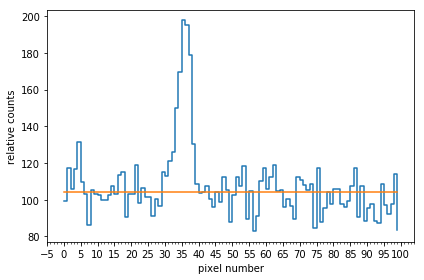

In [6]:
# plot your background model over the "image"

fig, ax = pixel_plot(x, sim_star)
pixel_plot(x,  np.repeat(S_estimate, len(x)), fig=fig, ax=ax)

### Problem 1.2) Estimate a the background as a ramp/line (order = 1)

Now let's simulate a slightly more complicated background a linear ramp: $y = 3x + 100$. First simulate the same star with the new background. Then we're going to fit it using the following steps:
* Bin the image
* Use your robust estimator to estimate the background value per bin center
* Fit these bin center with a model

* A common simple model that astronomers use are Chebyshev polynomials. Chebyshevs have some very nice properties that prevent ringing at the edges of the fit window. Another popular way to "model" the bin centers is non-parametrically via interpolation.

In [7]:
# Double check that your simulate function can take S optionally as array-like

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110d8ef98>)

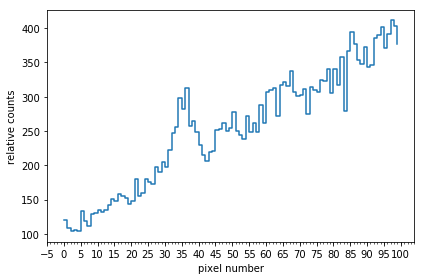

In [8]:
# Create and plot the image with S = 3*x + 100
S = S=(3*x + 100)
sim_star = simulate(x=x, mu=mu, fwhm=fwhm, S=S, F=F)
pixel_plot(x, sim_star)

In [9]:
# bin the image in 20-pixel bins 

# complete
BIN_SIZE = 20
bins = np.arange(0,  100 + BIN_SIZE, BIN_SIZE)
bin_centers = 0.5 *(bins[0:-1] + bins[1:])

digitized = np.digitize(x, bins=bins)
bin_values = [np.median(sim_star[digitized == i]) for i in range(1, len(bins))]

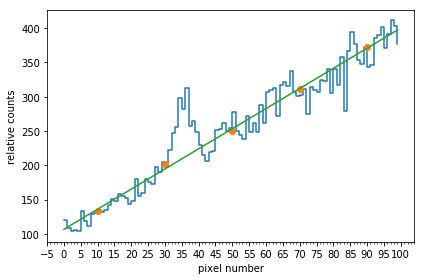

In [10]:
# Fit the bin_values vs bin_centers with a 1st-order chebyshev polynomial
# Evaluate your model for the full image
# hint: look up np.polynomial.chebyshev.chebfit and np.polynomial.chebyshev.chebeval

coefficients = np.polynomial.chebyshev.chebfit(bin_centers, bin_values, 1)
bg = np.polynomial.chebyshev.chebval(x, coefficients)

# Replot the image: 
fig, ax = pixel_plot(x, sim_star)
# binned values
ax.plot(bin_centers, bin_values, 'o')

# Overplot your background model:
ax.plot(x, bg, '-')

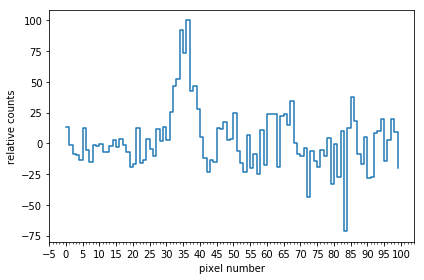

In [11]:
# Finally plot your background subtracted image:

fig, ax = pixel_plot(x, sim_star - bg)

### Problem 1.3) Estimate a more realistic background (still in 1D)

Now repeat the the exercise in problem 1.2 with a more complex background. 

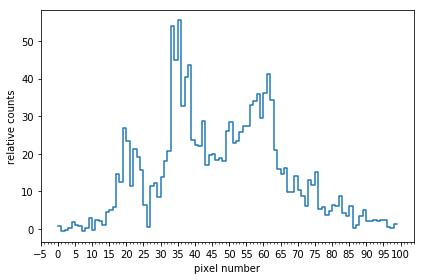

In [12]:
SIGMA_PER_FWHM = 2*np.sqrt(2*np.log(2))

fwhm = 5
x = np.arange(100)
background = 1000*norm.pdf(x, 50, 18) + 100*norm.pdf(x, 20, fwhm/SIGMA_PER_FWHM) + 100*norm.pdf(x, 60, fwhm/SIGMA_PER_FWHM)

sim_star3 = simulate(x=x, mu=35, fwhm=fwhm, S=background, F=200)
fig, ax = pixel_plot(x, sim_star3)

#### 1.3.1) Bin the image. Plot the bin centers. What bin size did you pick? 

In [13]:
BIN_SIZE = 10
bins = np.arange(0, 100 + BIN_SIZE, BIN_SIZE)
bin_centers = 0.5 *(bins[0:-1] + bins[1:])
print(bin_centers)

digitized = np.digitize(x, bins=bins)
bin_values = [np.median(sim_star3[digitized == i]) for i in range(1, len(bins))]

[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]


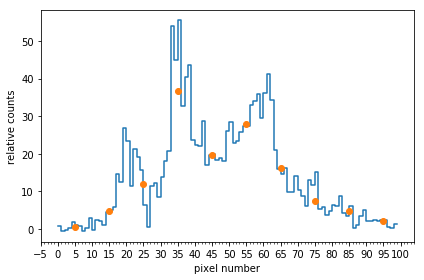

In [14]:
# overplot the binned esimtates:
fig, ax = pixel_plot(x, sim_star3)
ax.plot(bin_centers, bin_values, 'o')

#### 1.3.2) Spatially model the binned estimates (bin_values vs bin_centers) as a chebyshev polynomial.

Evaluate your model on the image grid and overplot.(what degree/order did you pick?)

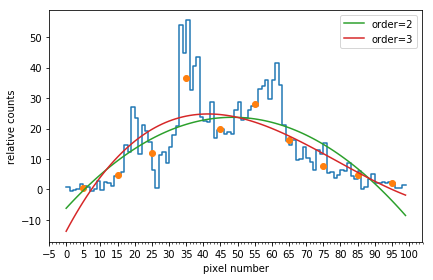

In [15]:
fig, ax = pixel_plot(x, sim_star3)
ax.plot(bin_centers, bin_values, 'o')

coefficients = np.polynomial.chebyshev.chebfit(bin_centers, bin_values, 2)
bg = np.polynomial.chebyshev.chebval(x, coefficients)
ax.plot(x, bg, '-', label='order=2')

coefficients = np.polynomial.chebyshev.chebfit(bin_centers, bin_values, 3)
bg = np.polynomial.chebyshev.chebval(x, coefficients)
ax.plot(x, bg, '-', label='order=3')

ax.legend()

#### 1.3.3) Subtract off the model and plot the "background-subtracted image." 

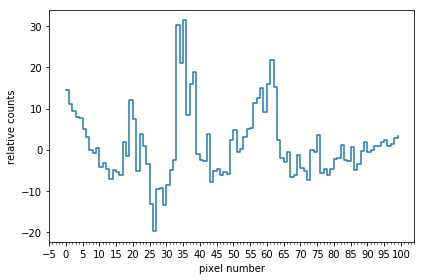

In [16]:
# Plot the background subtracted image
fig, ax = pixel_plot(x, sim_star3 - bg)

And now you can see that this problem is fairly unrealistic as far as background subtraction goes and should probably be treated with a deblender. Typically in images, 
* For chebyshev polynomials we use bin sizes of at least 128 pixels and orders of no more than 6. The spatial scale is controlled by the order, and bin size is less important. In fact you could probably use bin size of 1 if you really wanted to. 
* For interpolation, the spatial scale is controlled by the bin size. We usually choose bins >= 256 pixels.  

## Problem 2) Finding Sources

Now that we have subtracted background image,  let’s look for sources.  In the lecture we focused on the matched filter interpretation.  Here we will go into the hypothesis testing and maximum likelihood interpretations. 

### Maximum likelihood interpretation:

 Assume that we know there is a point source somewhere in this image.   We want to find  to pixel that has the maximum likelihood of having a point source centered on it.  recall from session 10, the probability for an  individual observation $I_i$ is:

$$P(X_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{-\frac{(X_i - y_i)^2}{2\sigma_i^2}}$$

Here: $X_i$ is the pixel value of pixel $i$ in the image and $y_i$ is the model prediction for that pixel. 

The model in this case is your `simulate()` function from the `IntroductionToBasicStellarPhotometry.ipynb` notebook: the PSF evaluated at a distance from the center multiplied by the flux amplitude: $F * \phi(x - x_{center}) + S$ Where $F$ is the flux amplitude $\phi$ is the PSF profile (a function of position), and $S$ is the background.

Plug it in:
$$P(X_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{-\frac{(X_i - (F * \phi_i(x_{center}) + S))^2}{2\sigma_i^2}}$$



### Hypothesis test interpretation:

If I were teaching source detection to my non-scientist, college stats 101 students, I'd frame the problem like this:

Pretend you have an infinitely large population of pixels Say I know definitively, that the arbitrarily large population of pixels is drawn from $N(0,100)$ (has a variance of 10). I have another sample of 13 pixels. I want to tesst the hypothesis that those 13 pixels were drawn from the $N(0,100)$ pop too. 

Test the hypothesis that your subsample of 13 pixels were drawn from the larger sample.
* $H_0$: $\mu = 0$
* $H_A$: $\mu > 0$

$$z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} $$
$$z = \frac{\sum{x}/13 - 0}{10 /\sqrt{13}} $$

OK, if this is coming back now, let's replace this with our *real* estimator for PSF flux, which is a *weighted mean* of the pixels where the weights are the PSF $\phi_i$. Whenever I forget the formulas for weighted means, I consult the [wikipedia page](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean).

Now tweak it for a weighted mean (PSF flux):

$$ z = \frac{\sum{\phi_i x_i} - \mu} {\sqrt{ \sum{\phi_i^2 \sigma_i^2}}} $$

Where the denominator is from the variance estimate of a weighted mean.  For constant $\sigma$ it reduces to $\sigma_{\bar{x}}^2 = \sigma^2 \sum{\phi^2_i}$, and for a constant $\phi$ this reduces to $\sigma_{\bar{x}}^2 = \sigma^2 /n$, the denomiator in the simple mean example above. Replace $\mu=0$ again. 

$$ z = \frac{\sum{\phi_i x_i}} {\sqrt{ \sum{\phi_i^2 \sigma_i^2}}} $$
Our detection map is just the nominator for each pixel! We deal with the denominator later when choosing the thresholding, but we could just as easily divide the whole image by the denominator and have a z-score image!

### 2.0) Plot the problem image

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a15bfeb38>)

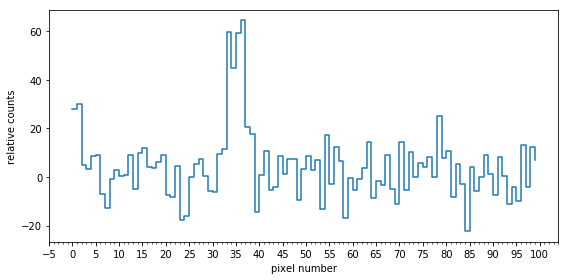

In [17]:
# set up simulation
x = np.arange(100)
mu = 35
S = 100
fwhm = 5
F = 300

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
sim_star = simulate(x, mu=mu, fwhm=fwhm, S=S, F=F)

# To simplify this pretend we know for sure the background = 100
# Plots the backround subtracted image
image = sim_star - 100
pixel_plot(x, image, fig=fig, ax=ax)

### 2.1) Make a kernel for the PSF.

Properties of kernels: They're centered at x=0 (which also means that they have an odd number of pixels) and sum up to 1. You can use your `phi()`.

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[0.00082002 0.00346709 0.01174297 0.03186112 0.06924917 0.12056981
 0.16816398 0.18788746 0.16816398 0.12056981 0.06924917 0.03186112
 0.01174297 0.00346709 0.00082002]


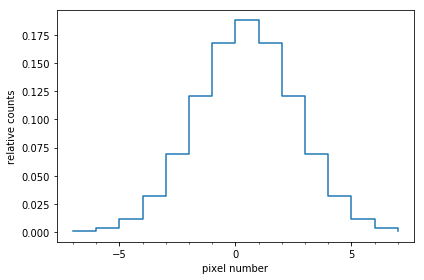

In [18]:

xx = np.arange(-7, 8)
kernel = phi(xx, mu=0, fwhm=5)
pixel_plot(xx, kernel)
print(xx)
print(kernel)

### 2.2) Correlate the image with the PSF kernel,

and plot the result.

What are the tradeoffs when choosing the size of your PSF kernel? What happens if its too big? What happens if it's too small.? 

**hint:** `scipy.signal.convolve`

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c166ad6a0>)

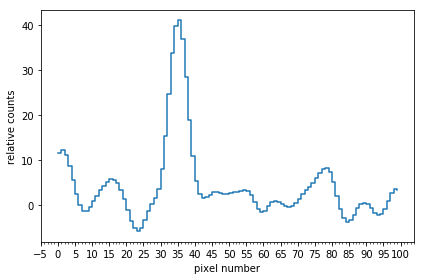

In [19]:
import scipy.signal

size = len(kernel)//2
detection_image = scipy.signal.convolve(image, kernel, mode='same')
#  mode='same' pads then clips the padding This is the same as:
#         size = len(kernel)//2
#         scipy.signal.convolve(image, kernel)[size:-size]


# Note: pay attention to how scipy.signal.convolve handles the edges. 
pixel_plot(x, detection_image)

In [20]:
print(len(scipy.signal.convolve(image, kernel, mode='full')))
print(len(scipy.signal.convolve(image, kernel, mode='same')))
print(len(scipy.signal.convolve(image, kernel, mode='valid')))


114
100
86


**Answer to the question:** Bigger PSF kernels =  more accurate convolution, more pixels lost on the edges, and more expensive computation. Smaller kernels don't get close enough to zero on the edges and resulting correlated image can look "boxy"

### 2.3) Detect pixels 

for which the null hypothesis that there's no source centered there is ruled out at the 5$\sigma$ level.

In [21]:
# Using a robust estimator for the detection image standard deviation,
# Compute the 5 sigma threshold
N_SIGMA = 5
q1, q2 = np.percentile(detection_image, (30.85, 69.15))
std = q2 - q1

threshold_value = std * N_SIGMA
print('5 sigma threshold value is = {:.4f}'.format(threshold_value))

5 sigma threshold value is = 16.2267


The noise estimate is a little high, but not bad for the first iteration. In future interations we will mask the fotoprints detected in the initial round, before recomputing. 

In practice, we use a sigma-clipped rms as the estimate of the standard deviation, in which we iteratively clip outliers until we have what looks like a normal distribution and compute a plain std. 

Text(0.5, 0, 'Normal quantiles')

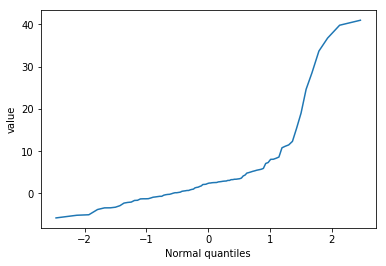

In [22]:
qq = scipy.stats.probplot(detection_image, dist="norm")
plt.plot(qq[0][0], qq[0][1])
plt.ylabel('value')
plt.xlabel('Normal quantiles')

# Just for fun to see what's going on:

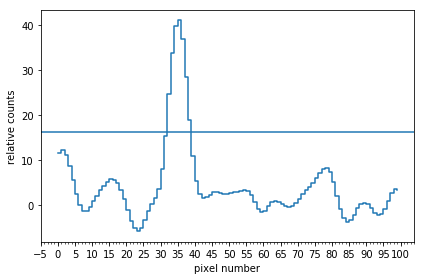

In [23]:
fig, ax = pixel_plot(x, detection_image)
plt.axhline(threshold_value)


### 2.4) Dilate footprint to provide a window or region for the point source.
We will use this window to compute the centroid and total flux of the star in the next two lessons. In the meantime, compute the flux like we did in introductionToStellarPhotometry assuming the input center. 

In [24]:
# complete
growBy = fwhm
mask = detection_image > threshold_value
print(np.count_nonzero(mask))
dilated_mask = scipy.ndimage.binary_dilation(mask, iterations=growBy)
print(np.count_nonzero(dilated_mask))

7
17


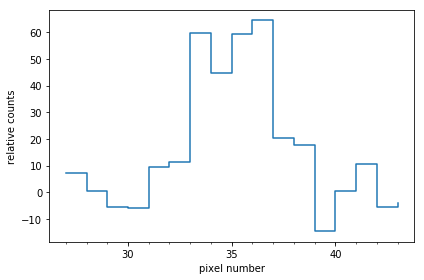

In [25]:
fig, ax = pixel_plot(x[dilated_mask], image[dilated_mask])

In [26]:
# easy aperture flux:
np.sum(image[dilated_mask])

270.6411783626849

In [27]:
# Copied from solutions of previous notebook

from scipy.optimize import minimize

psf = phi(x[dilated_mask], mu=35, fwhm=5)
im = image[dilated_mask]

# minimize the square of the residuals to determine flux
def sum_res(A, flux=im, model=psf):
    return sum((flux - A*model)**2)

sim_star = simulate(x, mu, fwhm, S, F)
psf_flux = minimize(sum_res, 300, args=(im, psf))

print("The PSF flux is {:.3f}".format(psf_flux.x[0]))

The PSF flux is 308.353


## Challenge problem A

Combine problem 1 and 2 to iterate background estimation and source detection, masking the pixels with detections. Use the more complex background from 1.3. 

## Challenge problem B

Repeat challenge problem A in two dimensions